# Machine Learning: a hands-on experience
## (this is just a teaser trailer!)


Always wanted to do some Machine Learning but only found online **fried air** and/or **useless and overpriced tips**?

<img src="fig/ml_everywhere.jpg" width="400"> <img src="fig/sas_ml.jpg" width="400">

# You are in the right place!

After all, if you are here, it means that you probably already have the right background and curiosity to understand these topics, you may just need the right tools to start playing with them.

### Hands on!
We will be using:
* $\texttt{R}$
    * it is *free*
    * you know it!
    * there is a ton of [online documentation](https://stackoverflow.com/questions/tagged/r+machine-learning?sort=votes&pageSize=15) (just in case)
* These **notebooks**
    * they are super cool

## And, most importantly...

## YOU CAN REPRODUCE IT  BY YOURSELF!!!

### YES, you don't even need a laptop (literally, you can do everything on your smartphone!)

<img src="fig/inception.jpeg" width="400">

___

Ever wondered what how do different ML models behave against different taks?

Then **run** the $\texttt{R}$ scripts here below!

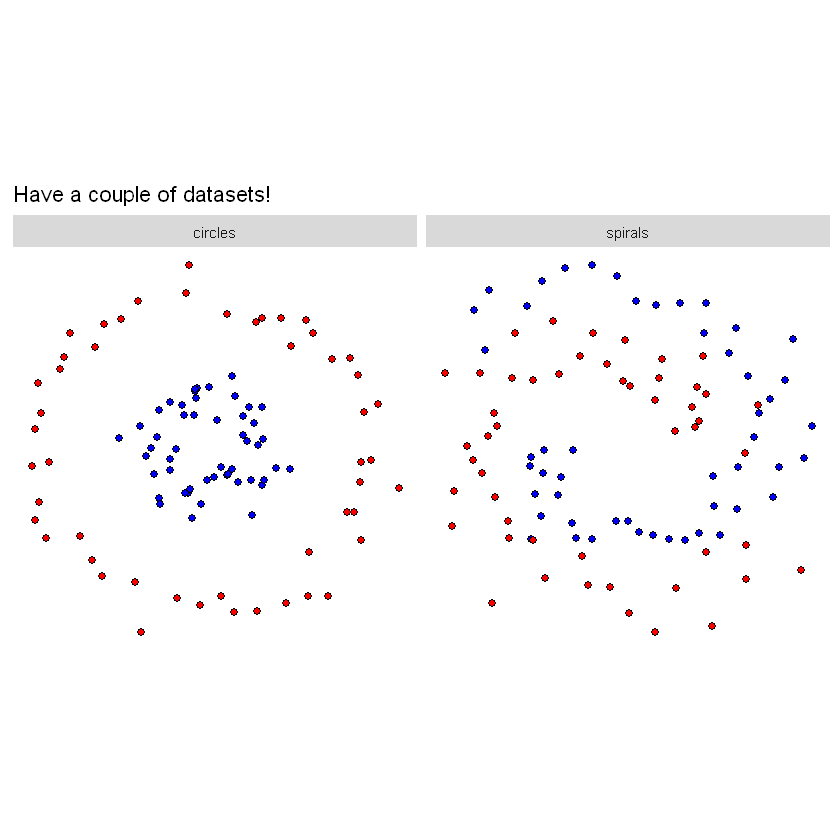

In [1]:
## plot a few datasets

source('src/lib.R')

get_full_dataset() %>% filter(type %in% c('circles', 'spirals')) %>%
  ggplot(aes(x = x, y = y, fill = class), color = 'black') +
  geom_point(size = 2, shape = 21) + 
  ggtitle('Have a couple of datasets!') + 
  theme(legend.position = "none", panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_blank(),
          axis.title=element_blank(),
          axis.text=element_blank(),
          axis.ticks=element_blank()) +
  scale_fill_manual(values = c("red", "blue"))+
  facet_wrap(~type) + coord_equal()

___

We will mostly look at **supervised classification**. A basic example is to classify some observations in a two-dimensional space. Let's try two different models:

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Joining, by = "tmp"


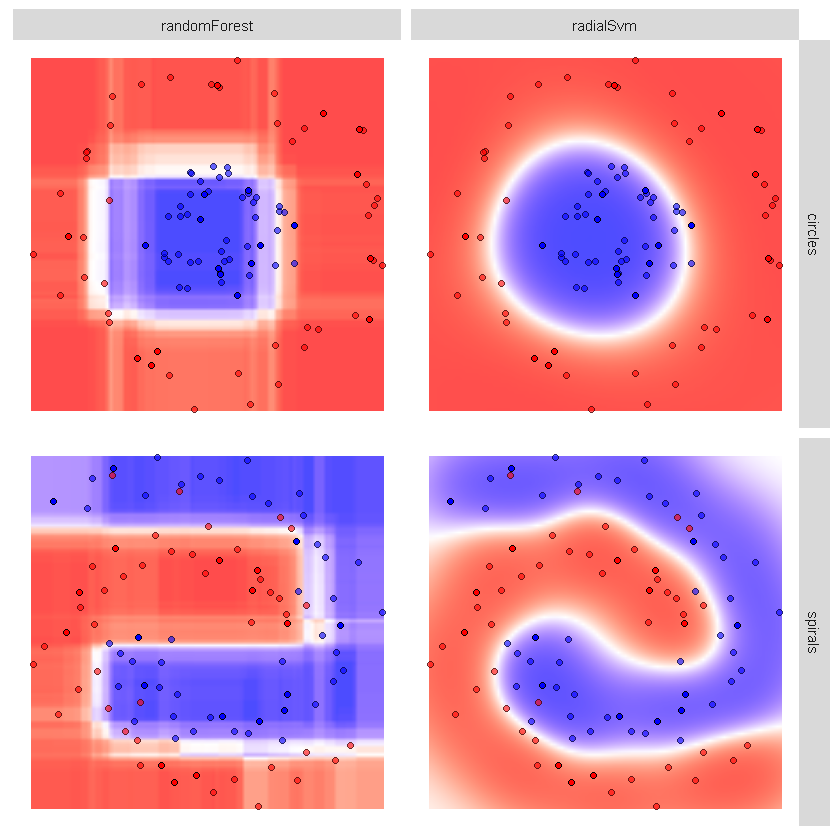

In [2]:
# try this out

methods = list()

methods = list('randomForest' = get_rf_model,
                'radialSvm' = get_radialSvm_model)

# train selected models ####
model = train_models(methods = methods)

# plot trained models ####

data = get_partitioned_df(include_full = F)
data = data[2:3]
plot_models(data, model)

Isn't that cool? Two different models behave differently for the same task, therefore **for each task we must find the most suitable model!**

___

And we will do *much more!*

<img src="fig/plot_models.png">

Supervised classification can solve very different problems belonging to very different fields.

In Credit Risk Management, the Probability of Default (PD) is a quantitative measure to split the obligors between the ones that are and are not likely to default. The algorithms we will see can easily be extended to a large number of dimensions, and effectively be used for **rating models**!

But the same framework can also be applied to a very different field such as **character recognition**. Imagine you have a grayscale image of a handwritten digit. Every pixel can be represented by a number, indicating how dark it is. The space of all possible handwritten digits (*0,...,9*) – which  has a number of dimensions equal to the number of pixels – can be split in the ones that represent **0**, the ones that represent **1** and so on... We can easy define a system to recognize handwritten digits automatically!

___

 Let's try to prototype a solution to this problem starting from the handwritten digits [MNIST](http://yann.lecun.com/exdb/mnist/]) dataset. The dataset contains a lot of labeled handwritten digits split in a training dataset and a test dataset: we will use the first one to train our model and the second one to assess its performance.

In [7]:
mnist <- dataset_mnist()

x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

Let's see some digits from the training set

Adding missing grouping variables: `label`
Joining, by = c("label", "index")


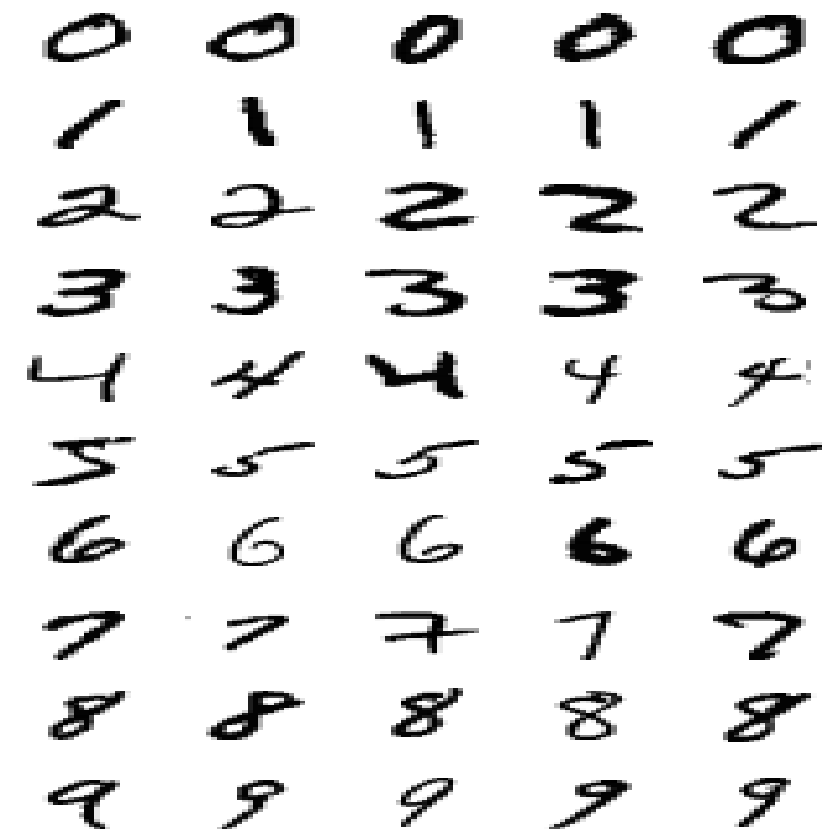

In [9]:
### Plot the data
prepare_pics_df <- function(pic_set, num_pics) {    
  pics_df <- 1:num_pics %>% 
    lapply(function(index) {
      img_mtx <- pic_set[index, ,]
      img_df <- data.frame(img_mtx)
      img_df$y <- 1:nrow(img_df)
      img_long_df <- img_df %>% gather(x, value, -y) %>%
        mutate(x = str_replace_all(x, "X", "") %>% as.integer) %>% 
        mutate(index = index, label = y_train[index]) 
      return(img_long_df)
    }) %>% bind_rows %>%
    mutate(label = factor(label, levels = 0:9))
}

# Get 100 pics from the train & test datasets
train_pics_df <- prepare_pics_df(x_train, 100)
test_pics_df <- prepare_pics_df(x_test, 100) 

# Remove labels from test data: we won't use them
test_pics_df <- test_pics_df %>% select(-label)

### Plot 5 samples for each digit in the training set
train_pics_df %>% group_by(index, label) %>% summarise(tot_pix = n()) %>% 
  group_by(label) %>% mutate(label_index = 1:n()) %>% filter(label_index <= 5) %>% 
  select(index, label_index) %>% inner_join(train_pics_df) %>% 
  ggplot(aes(x = x, y = y, fill = value)) + geom_tile() +
  facet_grid(label~label_index) + theme_void() + 
  scale_fill_gradient(low = "white", high = "black") + 
  guides(fill=FALSE) + scale_y_reverse() +
  theme(strip.text.x = element_blank(), strip.text.y = element_blank())

In [5]:
##### Start training

# reshape the data
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))

# rescale the data
x_train <- x_train / 255
x_test <- x_test / 255

y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

# declare the model
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(784), name = 'First_Layer') %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu', name = 'Second_Layer') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax', name = 'Output_Layer')

# istantiate the tensorflow C++ object
# set some training hyperparameters
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

# train the model
history <- model %>% fit(
  x_train, y_train, 
  epochs = 10, batch_size = 128, 
  validation_split = 0.2
)

### Now, will our model be able to recognize the numbers?
Let's take a look at the testing set...

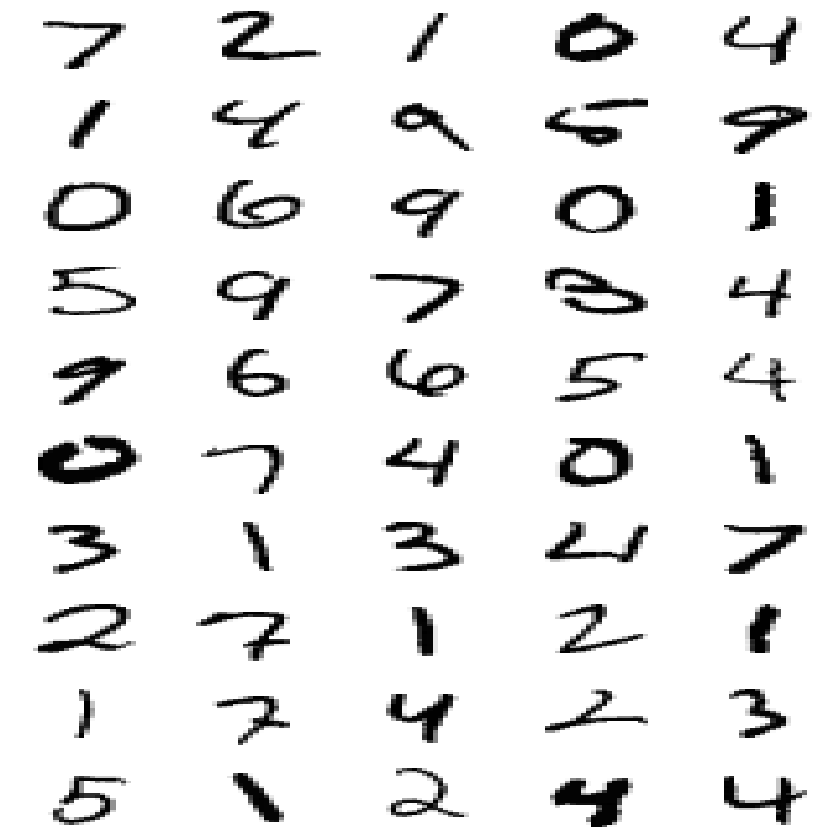

In [6]:
test_pics_df %>% filter(index <= 50) %>% ggplot(aes(x = x, y = y, fill = value)) + geom_tile() +
  facet_wrap(~index, ncol = 5) + theme_void() + 
  scale_fill_gradient(low = "white", high = "black") + 
  guides(fill=FALSE) + scale_y_reverse() +
  theme(strip.text.x = element_blank())

### Hey, A.I., where are my 2s?

Joining, by = "index"


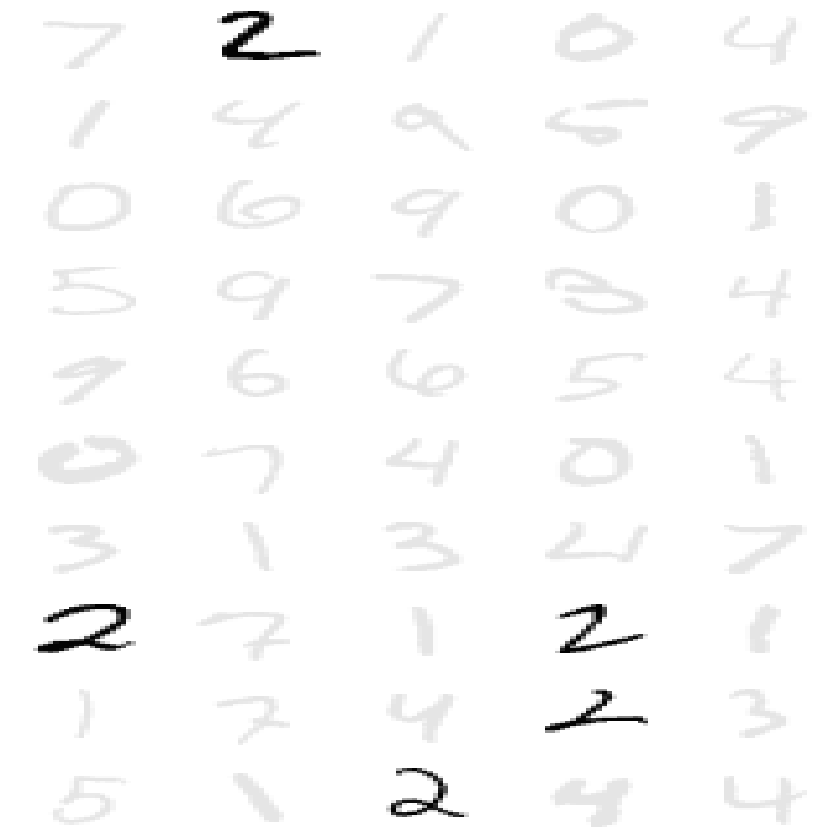

In [7]:
# Prediction on test dataset
prediction_df <- data_frame(
  index = test_pics_df$index %>% unique
) %>% mutate(
  prediction = sapply(index, function(i) {
    model %>% predict_classes(x_test[i,] %>% array_reshape(c(1, 784)))
  })
)

### OK A.I. where are the 2s?
test_pics_df %>% filter(index <= 50) %>% left_join(prediction_df) %>% 
  mutate(select = prediction == 2) %>% 
  ggplot(aes(x = x, y = y, fill = value, alpha = select)) + geom_tile() +
  facet_wrap(~index, ncol = 5) + theme_void() + 
  scale_fill_gradient(low = "white", high = "black") + 
  guides(fill=FALSE) + scale_y_reverse() + scale_alpha_discrete(0.5, guide=FALSE) +
  theme(strip.text.x = element_blank())

### Gotcha! And how about my 9s?

Joining, by = "index"


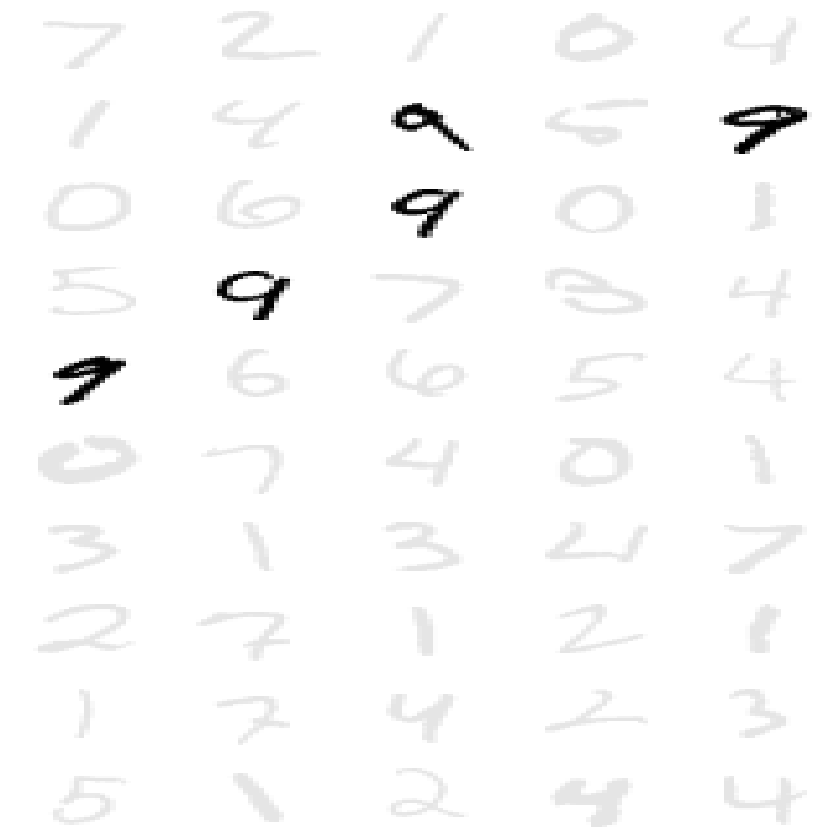

In [8]:
test_pics_df %>% filter(index <= 50) %>% left_join(prediction_df) %>% 
  mutate(select = prediction == 9) %>% 
  ggplot(aes(x = x, y = y, fill = value, alpha = select)) + geom_tile() +
  facet_wrap(~index, ncol = 5) + theme_void() + 
  scale_fill_gradient(low = "white", high = "black") + 
  guides(fill=FALSE) + scale_y_reverse() + scale_alpha_discrete(0.5, guide=FALSE) +
  theme(strip.text.x = element_blank())

### Yeah! Great!

___

So, what do you think, do you want to see more of this?
## Stay tuned!